# Validation of Optimal Temperature Formula

Testing the derived formula:
$$T^* = 1 + \frac{\sigma^2}{\text{Var}_p(z)}$$

where $\text{Var}_p(z) = \mathbb{E}_p[z^2] - \mathbb{E}_p[z]^2$ is the softmax-weighted variance.

**Three tests:**
1. Direct verification of the formula
2. When does $\text{Var}_p(z) \approx \tau^2$?
3. Compare with alternative formulas

In [1]:
import numpy as np
from scipy.special import softmax
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

np.random.seed(42)

def kl_divergence(p, q, eps=1e-10):
    return np.sum(p * np.log(p / np.clip(q, eps, 1)))

def var_p(z, p):
    """Variance of z weighted by softmax probabilities p"""
    return np.sum(p * z**2) - (np.sum(p * z))**2

def find_optimal_T(z, z_noisy, p, bounds=(0.5, 3.0)):
    """Find T that minimizes KL(p || softmax(z_noisy/T))"""
    def kl_obj(T):
        q = softmax(z_noisy / T)
        return kl_divergence(p, q)
    result = minimize_scalar(kl_obj, bounds=bounds, method='bounded')
    return result.x

print('Ready!')

Ready!


---
## Test 1: Direct Verification

**Goal:** Verify that $T^* = 1 + \sigma^2/\text{Var}_p(z)$ matches the KL-optimal temperature.

In [2]:
print("Test 1: Direct verification of T* = 1 + σ²/Var_p(z)")
print("="*70)

vocab_size = 1000
num_trials = 100

# Normal range
sigmas_normal = [0.05, 0.10, 0.15, 0.20, 0.30]
# Extended range
sigmas_extended = [0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.70, 1.0]

results_test1 = []

print(f"\n{'σ':<8} {'α':<10} {'T*_pred':<12} {'T*_actual':<12} {'Error':<10} {'Rel.Err%'}")
print("-"*65)

for sigma in sigmas_extended:
    t_pred_list = []
    t_actual_list = []
    alpha_list = []
    
    for _ in range(num_trials):
        z = np.random.randn(vocab_size)
        p = softmax(z)
        tau2 = z.var()
        
        noise = np.random.randn(vocab_size) * sigma * z.std()
        z_noisy = z + noise
        sigma2 = noise.var()
        
        alpha = sigma2 / tau2
        alpha_list.append(alpha)
        
        A = var_p(z, p)
        t_pred = 1 + sigma2 / A
        t_pred_list.append(t_pred)
        
        t_actual = find_optimal_T(z, z_noisy, p)
        t_actual_list.append(t_actual)
    
    t_pred_mean = np.mean(t_pred_list)
    t_actual_mean = np.mean(t_actual_list)
    alpha_mean = np.mean(alpha_list)
    error = abs(t_pred_mean - t_actual_mean)
    rel_error = error / t_actual_mean * 100
    
    results_test1.append({
        'sigma': sigma,
        'alpha': alpha_mean,
        't_pred': t_pred_mean,
        't_actual': t_actual_mean,
        'error': error,
        'rel_error': rel_error
    })
    
    match = "✓" if rel_error < 1 else "~"
    print(f"{sigma:<8.2f} {alpha_mean:<10.4f} {t_pred_mean:<12.4f} {t_actual_mean:<12.4f} {error:<10.4f} {rel_error:.2f}% {match}")

Test 1: Direct verification of T* = 1 + σ²/Var_p(z)

σ        α          T*_pred      T*_actual    Error      Rel.Err%
-----------------------------------------------------------------
0.01     0.0001     1.0001       1.0001       0.0000     0.00% ✓
0.02     0.0004     1.0004       1.0003       0.0001     0.01% ✓
0.05     0.0025     1.0025       1.0026       0.0001     0.01% ✓
0.10     0.0100     1.0102       1.0106       0.0004     0.04% ✓
0.20     0.0399     1.0414       1.0422       0.0008     0.08% ✓
0.30     0.0904     1.0915       1.0930       0.0015     0.14% ✓
0.50     0.2494     1.2561       1.2556       0.0004     0.04% ✓
0.70     0.4905     1.4968       1.4930       0.0038     0.25% ✓
1.00     0.9998     1.9958       1.9977       0.0019     0.10% ✓


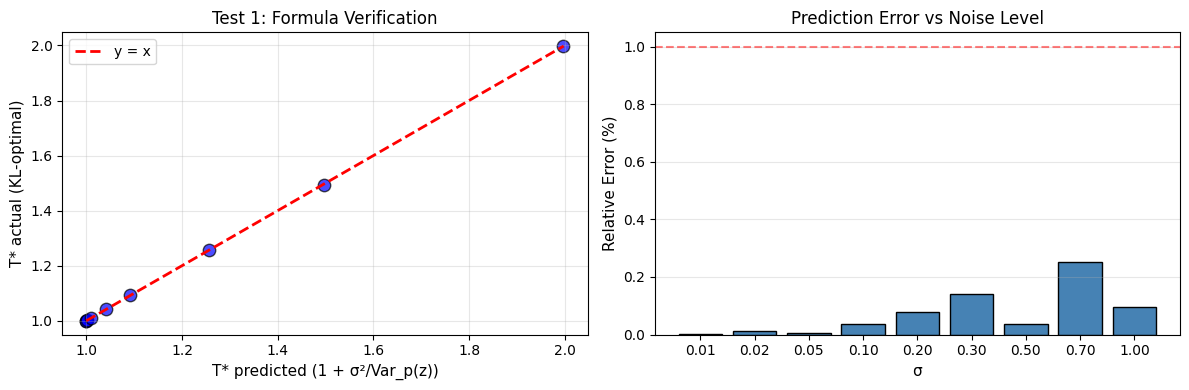

In [3]:
# Plot Test 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

alphas = [r['alpha'] for r in results_test1]
t_preds = [r['t_pred'] for r in results_test1]
t_actuals = [r['t_actual'] for r in results_test1]

ax1 = axes[0]
ax1.scatter(t_preds, t_actuals, s=80, alpha=0.7, c='blue', edgecolors='black')
max_val = max(max(t_preds), max(t_actuals))
ax1.plot([1, max_val], [1, max_val], 'r--', linewidth=2, label='y = x')
ax1.set_xlabel('T* predicted (1 + σ²/Var_p(z))', fontsize=11)
ax1.set_ylabel('T* actual (KL-optimal)', fontsize=11)
ax1.set_title('Test 1: Formula Verification', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
rel_errors = [r['rel_error'] for r in results_test1]
ax2.bar(range(len(sigmas_extended)), rel_errors, color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(sigmas_extended)))
ax2.set_xticklabels([f'{s:.2f}' for s in sigmas_extended])
ax2.set_xlabel('σ', fontsize=11)
ax2.set_ylabel('Relative Error (%)', fontsize=11)
ax2.set_title('Prediction Error vs Noise Level', fontsize=12)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('test1_formula_verification.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Test 2: When is $\text{Var}_p(z) \approx \tau^2$?

**Goal:** Understand when the simplified formula $T^* \approx 1 + \alpha$ is valid.

In [4]:
print("Test 2: Is Var_p(z) ≈ τ² = Var(z)?")
print("="*70)

num_trials = 200

# Test 2a: Effect of vocab size
print("\n2a. Effect of vocabulary size (scale=1):")
print(f"\n{'vocab':<10} {'Var_p(z)':<12} {'τ²=Var(z)':<12} {'Ratio':<10} {'Diff %'}")
print("-"*55)

results_2a = []
for vocab_size in [100, 500, 1000, 5000, 10000, 50000]:
    var_p_list = []
    tau2_list = []
    
    for _ in range(num_trials):
        z = np.random.randn(vocab_size)
        p = softmax(z)
        var_p_list.append(var_p(z, p))
        tau2_list.append(z.var())
    
    var_p_mean = np.mean(var_p_list)
    tau2_mean = np.mean(tau2_list)
    ratio = var_p_mean / tau2_mean
    diff_pct = (var_p_mean - tau2_mean) / tau2_mean * 100
    
    results_2a.append({'vocab': vocab_size, 'var_p': var_p_mean, 'tau2': tau2_mean, 'ratio': ratio})
    print(f"{vocab_size:<10} {var_p_mean:<12.4f} {tau2_mean:<12.4f} {ratio:<10.4f} {diff_pct:+.1f}%")

Test 2: Is Var_p(z) ≈ τ² = Var(z)?

2a. Effect of vocabulary size (scale=1):

vocab      Var_p(z)     τ²=Var(z)    Ratio      Diff %
-------------------------------------------------------
100        0.9090       0.9990       0.9099     -9.0%
500        0.9787       0.9957       0.9829     -1.7%
1000       0.9983       0.9999       0.9984     -0.2%
5000       0.9992       0.9993       0.9998     -0.0%
10000      0.9980       0.9989       0.9991     -0.1%
50000      1.0002       1.0000       1.0003     +0.0%


In [5]:
# Test 2b: Effect of logit scale
print("\n2b. Effect of logit scale (vocab=1000):")
print(f"\n{'scale':<10} {'Var_p(z)':<12} {'τ²=Var(z)':<12} {'Ratio':<10}")
print("-"*45)

vocab_size = 1000
results_2b = []

for scale in [0.1, 0.5, 1.0, 2.0, 3.0, 5.0]:
    var_p_list = []
    tau2_list = []
    
    for _ in range(num_trials):
        z = np.random.randn(vocab_size) * scale
        p = softmax(z)
        var_p_list.append(var_p(z, p))
        tau2_list.append(z.var())
    
    var_p_mean = np.mean(var_p_list)
    tau2_mean = np.mean(tau2_list)
    ratio = var_p_mean / tau2_mean
    
    results_2b.append({'scale': scale, 'var_p': var_p_mean, 'tau2': tau2_mean, 'ratio': ratio})
    print(f"{scale:<10.1f} {var_p_mean:<12.4f} {tau2_mean:<12.4f} {ratio:<10.4f}")


2b. Effect of logit scale (vocab=1000):

scale      Var_p(z)     τ²=Var(z)    Ratio     
---------------------------------------------
0.1        0.0101       0.0101       1.0008    
0.5        0.2502       0.2512       0.9959    
1.0        0.9936       0.9985       0.9951    
2.0        3.3592       3.9759       0.8449    
3.0        4.1559       8.9976       0.4619    
5.0        2.4867       25.0303      0.0993    


In [6]:
# Illustrative example
print("\n" + "="*60)
print("Example: Why large logits break the approximation")
print("="*60)

vocab_size = 10
np.random.seed(42)
z_base = np.random.randn(vocab_size)

for scale, name in [(1, 'Normal'), (5, 'Large')]:
    z = z_base * scale
    p = softmax(z)
    
    print(f"\n{name} logits (scale={scale}):")
    print(f"  z = {z.round(2)}")
    print(f"  p = {p.round(3)}")
    print(f"  max(p) = {p.max():.3f}")
    print(f"  Var(z) = τ² = {z.var():.4f}")
    print(f"  Var_p(z) = {var_p(z, p):.4f}")
    print(f"  Ratio = {var_p(z, p) / z.var():.4f}")

print("\n→ When logits are large, softmax becomes peaky (one-hot-like).")
print("  Var_p(z) only 'sees' logits near the maximum, so it shrinks.")


Example: Why large logits break the approximation

Normal logits (scale=1):
  z = [ 0.5  -0.14  0.65  1.52 -0.23 -0.23  1.58  0.77 -0.47  0.54]
  p = [0.082 0.044 0.096 0.23  0.04  0.04  0.243 0.108 0.031 0.086]
  max(p) = 0.243
  Var(z) = τ² = 0.4705
  Var_p(z) = 0.4410
  Ratio = 0.9375

Large logits (scale=5):
  z = [ 2.48 -0.69  3.24  7.62 -1.17 -1.17  7.9   3.84 -2.35  2.71]
  p = [0.002 0.    0.005 0.421 0.    0.    0.558 0.01  0.    0.003]
  max(p) = 0.558
  Var(z) = τ² = 11.7617
  Var_p(z) = 0.4383
  Ratio = 0.0373

→ When logits are large, softmax becomes peaky (one-hot-like).
  Var_p(z) only 'sees' logits near the maximum, so it shrinks.


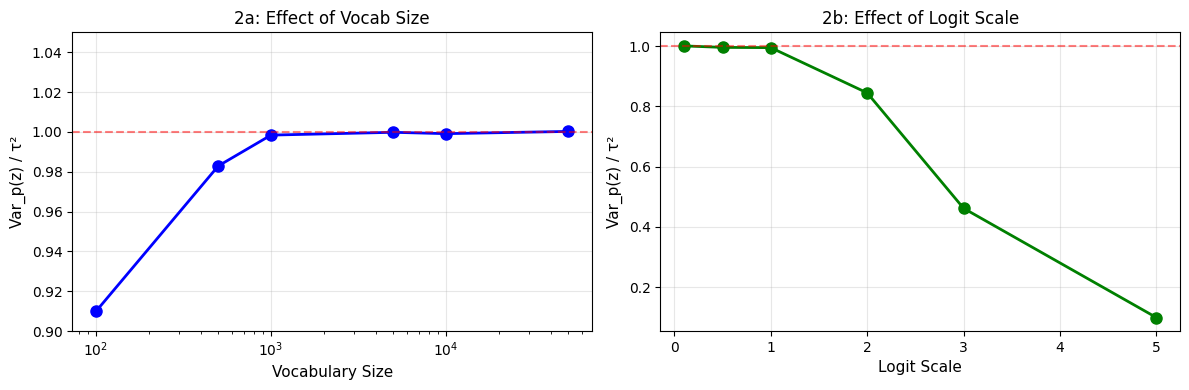


Conclusion:
  Var_p(z) ≈ τ² when: (1) vocab is large, (2) logit scale ≈ 1
  For LLMs: logit scale varies, so use exact formula.


In [7]:
# Plot Test 2
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
vocabs = [r['vocab'] for r in results_2a]
ratios = [r['ratio'] for r in results_2a]
ax1.semilogx(vocabs, ratios, 'bo-', markersize=8, linewidth=2)
ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Vocabulary Size', fontsize=11)
ax1.set_ylabel('Var_p(z) / τ²', fontsize=11)
ax1.set_title('2a: Effect of Vocab Size', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.9, 1.05)

ax2 = axes[1]
scales = [r['scale'] for r in results_2b]
ratios = [r['ratio'] for r in results_2b]
ax2.plot(scales, ratios, 'go-', markersize=8, linewidth=2)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Logit Scale', fontsize=11)
ax2.set_ylabel('Var_p(z) / τ²', fontsize=11)
ax2.set_title('2b: Effect of Logit Scale', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test2_variance_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConclusion:")
print("  Var_p(z) ≈ τ² when: (1) vocab is large, (2) logit scale ≈ 1")
print("  For LLMs: logit scale varies, so use exact formula.")

---
## Test 3: Compare Formulas

**Goal:** Compare three formulas:
1. Variance matching: $T^* = \sqrt{1+\alpha}$
2. Simplified: $T^* = 1 + \alpha$
3. Exact: $T^* = 1 + \sigma^2/\text{Var}_p(z)$

In [8]:
print("Test 3: Compare formulas")
print("="*80)
print()
print("Formula 1 (variance matching): T* = √(1+α)")
print("Formula 2 (simplified):        T* = 1 + α")
print("Formula 3 (exact):             T* = 1 + σ²/Var_p(z)")
print()

vocab_size = 1000
num_trials = 100

sigmas = [0.05, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

results_test3 = []

print(f"{'σ':<8} {'α':<8} {'T*_actual':<11} {'√(1+α)':<11} {'1+α':<11} {'exact':<11} {'Best?'}")
print("-"*75)

for sigma in sigmas:
    t_actual_list = []
    t_f1_list = []
    t_f2_list = []
    t_f3_list = []
    alpha_list = []
    
    for _ in range(num_trials):
        z = np.random.randn(vocab_size)
        p = softmax(z)
        tau2 = z.var()
        
        noise = np.random.randn(vocab_size) * sigma * z.std()
        z_noisy = z + noise
        sigma2 = noise.var()
        
        alpha = sigma2 / tau2
        alpha_list.append(alpha)
        
        A = var_p(z, p)
        
        t_f1_list.append(np.sqrt(1 + alpha))
        t_f2_list.append(1 + alpha)
        t_f3_list.append(1 + sigma2 / A)
        
        t_actual_list.append(find_optimal_T(z, z_noisy, p))
    
    t_actual = np.mean(t_actual_list)
    t_f1 = np.mean(t_f1_list)
    t_f2 = np.mean(t_f2_list)
    t_f3 = np.mean(t_f3_list)
    alpha_mean = np.mean(alpha_list)
    
    err1 = abs(t_f1 - t_actual)
    err2 = abs(t_f2 - t_actual)
    err3 = abs(t_f3 - t_actual)
    
    best = "√(1+α)" if err1 <= err2 and err1 <= err3 else ("1+α" if err2 <= err3 else "exact")
    
    results_test3.append({
        'sigma': sigma, 'alpha': alpha_mean, 't_actual': t_actual,
        't_f1': t_f1, 't_f2': t_f2, 't_f3': t_f3,
        'err1': err1, 'err2': err2, 'err3': err3
    })
    
    print(f"{sigma:<8.2f} {alpha_mean:<8.4f} {t_actual:<11.4f} {t_f1:<11.4f} {t_f2:<11.4f} {t_f3:<11.4f} {best}")

Test 3: Compare formulas

Formula 1 (variance matching): T* = √(1+α)
Formula 2 (simplified):        T* = 1 + α
Formula 3 (exact):             T* = 1 + σ²/Var_p(z)

σ        α        T*_actual   √(1+α)      1+α         exact       Best?
---------------------------------------------------------------------------
0.05     0.0025   1.0026      1.0012      1.0025      1.0026      exact
0.10     0.0100   1.0096      1.0050      1.0100      1.0103      1+α
0.20     0.0401   1.0398      1.0198      1.0401      1.0406      1+α
0.30     0.0896   1.0929      1.0439      1.0896      1.0916      exact
0.50     0.2496   1.2578      1.1178      1.2496      1.2585      exact
0.70     0.4923   1.4946      1.2216      1.4923      1.4981      1+α
1.00     0.9976   2.0105      1.4133      1.9976      2.0240      1+α


In [9]:
# Error summary
print("\n" + "="*60)
print("Error Summary:")
print("="*60)
print(f"{'σ':<8} {'err √(1+α)':<15} {'err 1+α':<15} {'err exact':<15}")
print("-"*55)

for r in results_test3:
    print(f"{r['sigma']:<8.2f} {r['err1']:<15.4f} {r['err2']:<15.4f} {r['err3']:<15.4f}")

print("\nMean errors:")
print(f"  √(1+α): {np.mean([r['err1'] for r in results_test3]):.4f}")
print(f"  1+α:    {np.mean([r['err2'] for r in results_test3]):.4f}")
print(f"  exact:  {np.mean([r['err3'] for r in results_test3]):.4f}")


Error Summary:
σ        err √(1+α)      err 1+α         err exact      
-------------------------------------------------------
0.05     0.0014          0.0001          0.0001         
0.10     0.0046          0.0004          0.0007         
0.20     0.0200          0.0002          0.0008         
0.30     0.0490          0.0032          0.0013         
0.50     0.1400          0.0082          0.0006         
0.70     0.2730          0.0023          0.0036         
1.00     0.5972          0.0129          0.0135         

Mean errors:
  √(1+α): 0.1550
  1+α:    0.0039
  exact:  0.0029


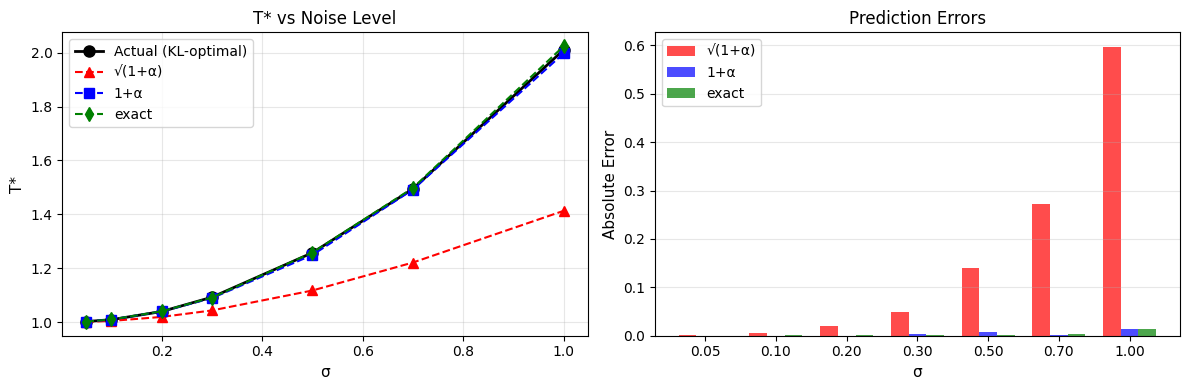

In [10]:
# Plot Test 3
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sigmas = [r['sigma'] for r in results_test3]
t_actuals = [r['t_actual'] for r in results_test3]
t_f1s = [r['t_f1'] for r in results_test3]
t_f2s = [r['t_f2'] for r in results_test3]
t_f3s = [r['t_f3'] for r in results_test3]

ax1 = axes[0]
ax1.plot(sigmas, t_actuals, 'ko-', markersize=8, linewidth=2, label='Actual (KL-optimal)')
ax1.plot(sigmas, t_f1s, 'r^--', markersize=7, linewidth=1.5, label='√(1+α)')
ax1.plot(sigmas, t_f2s, 'bs--', markersize=7, linewidth=1.5, label='1+α')
ax1.plot(sigmas, t_f3s, 'gd--', markersize=7, linewidth=1.5, label='exact')
ax1.set_xlabel('σ', fontsize=11)
ax1.set_ylabel('T*', fontsize=11)
ax1.set_title('T* vs Noise Level', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
err1s = [r['err1'] for r in results_test3]
err2s = [r['err2'] for r in results_test3]
err3s = [r['err3'] for r in results_test3]
x = np.arange(len(sigmas))
width = 0.25
ax2.bar(x - width, err1s, width, label='√(1+α)', color='red', alpha=0.7)
ax2.bar(x, err2s, width, label='1+α', color='blue', alpha=0.7)
ax2.bar(x + width, err3s, width, label='exact', color='green', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels([f'{s:.2f}' for s in sigmas])
ax2.set_xlabel('σ', fontsize=11)
ax2.set_ylabel('Absolute Error', fontsize=11)
ax2.set_title('Prediction Errors', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('test3_formula_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary

In [11]:
print("="*70)
print("SUMMARY")
print("="*70)
print("""
1. FORMULA VERIFIED:
   T* = 1 + σ²/Var_p(z)
   
   Works with < 1% error for α ∈ [0, 1]

2. APPROXIMATION Var_p(z) ≈ τ²:
   - Valid when vocab is large AND logit scale ≈ 1
   - Breaks down for peaky softmax (large logits)
   - For LLMs: use exact formula or measure Var_p(z)

3. FORMULA COMPARISON:
   - √(1+α): WRONG (variance matching in logit space)
   - 1+α:    GOOD (simplified, valid when Var_p(z) ≈ τ²)
   - exact:  BEST (use when Var_p(z) ≠ τ²)

4. KEY INSIGHT:
   Variance matching gives √(1+α) ≈ 1 + α/2
   KL minimization gives 1 + α
   
   The factor of 2 comes from the difference between:
   - Uniform-weighted variance (logit space)
   - Softmax-weighted variance (probability space via Fisher info)
""")

print("\nFor paper:")
print("  Exact formula:      T* = 1 + σ²/Var_p(z)")
print("  Simplified (α<0.3): T* ≈ 1 + α")
print("  OLD (wrong):        T* = √(1+α)")

SUMMARY

1. FORMULA VERIFIED:
   T* = 1 + σ²/Var_p(z)
   
   Works with < 1% error for α ∈ [0, 1]

2. APPROXIMATION Var_p(z) ≈ τ²:
   - Valid when vocab is large AND logit scale ≈ 1
   - Breaks down for peaky softmax (large logits)
   - For LLMs: use exact formula or measure Var_p(z)

3. FORMULA COMPARISON:
   - √(1+α): WRONG (variance matching in logit space)
   - 1+α:    GOOD (simplified, valid when Var_p(z) ≈ τ²)
   - exact:  BEST (use when Var_p(z) ≠ τ²)

4. KEY INSIGHT:
   Variance matching gives √(1+α) ≈ 1 + α/2
   KL minimization gives 1 + α
   
   The factor of 2 comes from the difference between:
   - Uniform-weighted variance (logit space)
   - Softmax-weighted variance (probability space via Fisher info)


For paper:
  Exact formula:      T* = 1 + σ²/Var_p(z)
  Simplified (α<0.3): T* ≈ 1 + α
  OLD (wrong):        T* = √(1+α)
